# **Final Project of Computer Vision Course Fall 2022 Shahid Beheshti University**
## **Mohammadhossein Arsalan 98243005**


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_lfw_pairs as flp
import os

I searched about our dataset and found out that sklearn datasets include our desired dataset for this project, sklearn has two datasets of lfw which one of them contains pairs of photos labeled whether they're same or not. also this dataset can divide our train set and test set so its easier to use it for machine learning task. 

In [2]:
# pictures = flp(subset="train")
# test = flp(subset="test")

data_home = os.path.expanduser('scikit_learn_data')
pictures = flp(subset="train", data_home=data_home)
test = flp(subset="test", data_home=data_home)

based on sklearn.datasets documentation for lfw, our pictures and test are dictionaries which contains keys as shown below
<br />
**data** : both pictures + label of similarity together
<br />
**pairs**: only two pictures
<br />
**target**: label of the similarity of two pictures

In [3]:
pictures.keys()

dict_keys(['data', 'pairs', 'target', 'target_names', 'DESCR'])

We access 2200 picture pairs, each one 62x47 pixels 

In [4]:
pictures['pairs'].shape

(2200, 2, 62, 47)

In [5]:
test['pairs'].shape

(1000, 2, 62, 47)

In [6]:
# pictures

We can see an example of our pictures set elements in **pairs** key
<br /> 
result is plotted :) also you can see the label which is assigned to this pair, so these two pictures are same person so target is 1 which means true similarity

these faces are same person? 1


<Figure size 640x480 with 0 Axes>

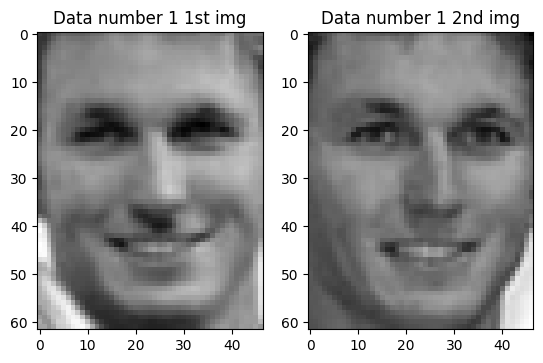

In [7]:
plt.figure()
fig, axs = plt.subplots(1,2)
axs[0].imshow(pictures['pairs'][0][0], cmap='gray')
axs[0].set_title('Data number 1 1st img')
axs[1].imshow(pictures['pairs'][0][1], cmap='gray')
axs[1].set_title('Data number 1 2nd img')
target = pictures['target'][0]
print(f'these faces are same person? {target}')

For our feature extraction of our pictures I used a method in cv2 package, SIFT is a method described in project description; it do feature transforming with no interest in scale of pictures (although we have same scale pictures), so we create a instance of sift feature extractor which is specially for 2d pictures.

In [8]:
import cv2

In [9]:
# sift = cv2.xfeatures2d.SIFT_create()
sift = cv2.SIFT_create()

To set labels based on matches, I made a feature of similarity which is result of division shown below:

$$ {Number Of Matches \over min(featuresInPictures)} $$

if the division result occurs between x (our threshhold) and 1, target will be set to 1, otherwise (less than x) 0.
<br/>
we'll train our model on train_set (pictures) to learn appropriate value for x (threshhold)
<br /> 
In method defined below we recieve two images and by help of sift we find some special points in each picture and then by finding distance between this special points we can match pictures.
<br/>
At last we return the feature we want for training our model. 

In [10]:
def compute_similarity(face1, face2):
    # Ensure the images are of type uint8
    face1 = (face1 * 255).astype('uint8') if face1.dtype == 'float32' else face1
    face2 = (face2 * 255).astype('uint8') if face2.dtype == 'float32' else face2

    # Detect keypoints and compute descriptors
    features1, descriptors_1 = sift.detectAndCompute(face1, None)
    features2, descriptors_2 = sift.detectAndCompute(face2, None)

    # Check if descriptors are valid (i.e., not None)
    if descriptors_1 is None or descriptors_2 is None:
        return 0  # Return 0 similarity if no descriptors are found

    # Use BFMatcher for feature matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf.match(descriptors_1, descriptors_2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Avoid division by zero and calculate similarity
    min_desc_len = min(len(descriptors_1), len(descriptors_2))
    if min_desc_len == 0:
        return 0  # Return 0 if one of the images has no descriptors

    return len(matches) / min_desc_len

as an example we'll do the method compute_similarity visionally below to see how we find and match features in two input pictures.
<br/>
Matched special points are connected colorfull while not matched ones are only shown in black color

uint8 29 240
uint8 35 216
12 matches found in features


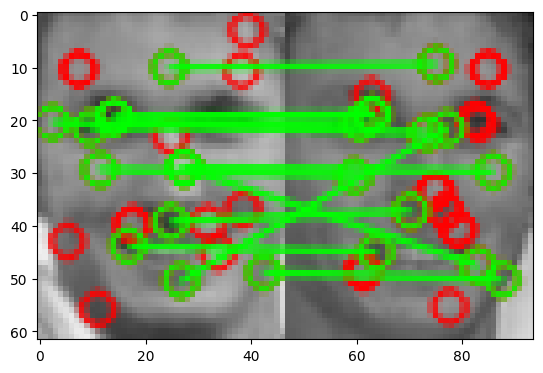

In [11]:
face1 = pictures['pairs'][0][0]
face2 = pictures['pairs'][0][1]
# Scale the images to uint8 format
face1 = (face1 * 255).astype('uint8')
face2 = (face2 * 255).astype('uint8')

# Verify the new data type and range
print(face1.dtype, face1.min(), face1.max())
print(face2.dtype, face2.min(), face2.max())

# Create a SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
features1, descriptors_1 = sift.detectAndCompute(face1, None)
features2, descriptors_2 = sift.detectAndCompute(face2, None)

if descriptors_1 is not None and descriptors_2 is not None:
    # Use BFMatcher for feature matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf.match(descriptors_1, descriptors_2)
    matches = sorted(matches, key=lambda x: x.distance)

    print(f'{len(matches)} matches found in features')

    # Draw matches
    matches_img = cv2.drawMatches(face1, features1, face2, features2, matches, None,
                                  matchColor=(0, 255, 0), singlePointColor=(255, 0, 0))
    plt.imshow(matches_img)
    plt.show()
else:
    print('No features found in one or both images.')


We compute the similarity feature (return value of the previous-defined method) for every pair in our set named pictures.

In [12]:
similarities = [compute_similarity(face1, face2) for face1, face2 in pictures['pairs']]

In [13]:
len(similarities)

2200

In [14]:
# similarities

In [15]:
pictures['target'].shape
np.array(similarities).shape

(2200,)

Now we give the similarities and targets from train_set (pictures) to a logistic regressor to learn a threshhold for future predictions

In [16]:
from sklearn.linear_model import LogisticRegression as LGR
from sklearn.metrics import f1_score as f1

In [17]:
model = LGR()
array_sims = np.array(similarities).reshape(-1,1)
model.fit(X=array_sims, y=pictures['target'])

LogisticRegression()

Our predict method recieve every pair in test set and compute the similarity (our metric is defined in the compute_similarity method) of them and then by using our model which is a logistic regressor we predict a label for this pair, when its 0 it means that two pictures belongs to two different people, and if its 1 it means that both pictures belong to one person. 

In [18]:
def predict(data, model):
  similarities = np.array([compute_similarity(face1, face2) for face1, face2 in data]).reshape(-1,1)
  predictions = [model.predict(sim.reshape(-1,1)) for sim in similarities]
  return predictions

In [19]:
predictions = predict(test['pairs'], model)
# predictions

now we see some examples of our model predictions, we generate some rnadom numbers and we show the result of prediction on the generated numbers in test set.

In [20]:
import random

In [21]:
def test_model(number_of_tests, predictions): 
  random_numbers = random.sample(range(0, 1000), number_of_tests)
  for img_no in random_numbers:
    plt.figure()
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(test['pairs'][img_no][0], cmap='gray')
    axs[0].set_title(f'Test number {img_no} 1st img')
    axs[1].imshow(test['pairs'][img_no][1], cmap='gray')
    axs[1].set_title(f'Test number {img_no} 2nd img')
    real_result = test['target'][img_no]
    pred_result = predictions[img_no]
    print(f'test number {img_no} => these faces are same person? predict:{pred_result[0]}  reality:{real_result} => correct_pred? {pred_result == real_result}')

test number 479 => these faces are same person? predict:1  reality:1 => correct_pred? [ True]
test number 323 => these faces are same person? predict:1  reality:1 => correct_pred? [ True]
test number 161 => these faces are same person? predict:0  reality:1 => correct_pred? [False]
test number 599 => these faces are same person? predict:0  reality:0 => correct_pred? [ True]
test number 422 => these faces are same person? predict:1  reality:1 => correct_pred? [ True]


<Figure size 640x480 with 0 Axes>

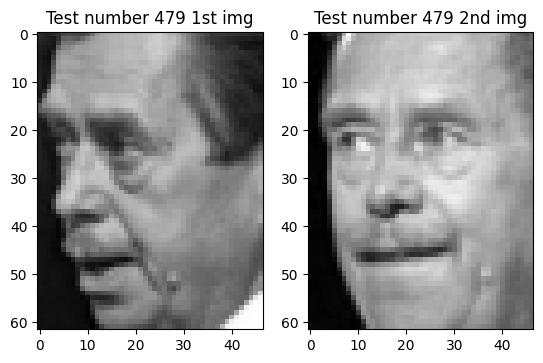

<Figure size 640x480 with 0 Axes>

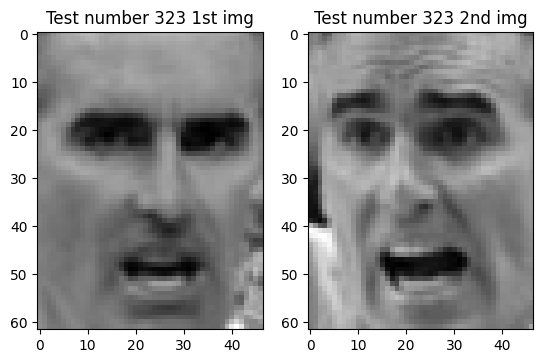

<Figure size 640x480 with 0 Axes>

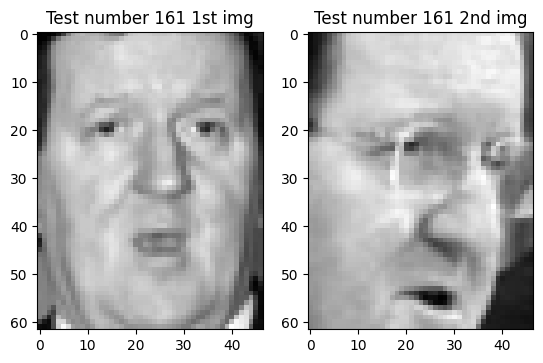

<Figure size 640x480 with 0 Axes>

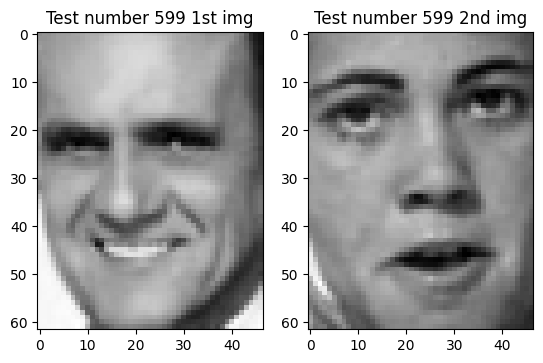

<Figure size 640x480 with 0 Axes>

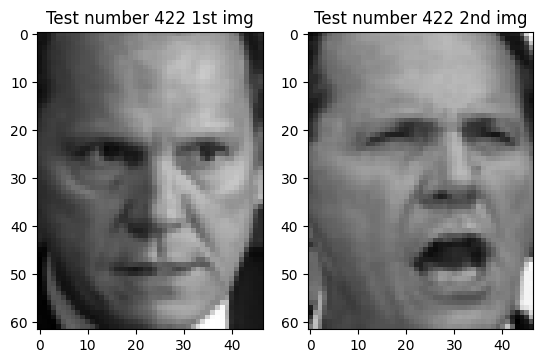

In [22]:
test_model(5, predictions)

# **Model Evaluation**
We use f1 score which is harmonic mean of percision and recall, percision is rate of true predicts of (0)s or (1)s in every (0)s or (1)s predictions.

In [25]:
# def eval_model(target, predictions):
  # print(f'f1 score for this model: {f1(target, predictions)}')
from sklearn.metrics import accuracy_score, precision_score, f1_score

def eval_model(target, predictions):
    accuracy = accuracy_score(target, predictions)
    precision = precision_score(target, predictions, average='binary')  # Change 'binary' to 'micro', 'macro', etc., if needed
    f1 = f1_score(target, predictions)

    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'F1 Score: {f1:.2f}')



In [26]:
eval_model(test['target'], predictions)

Accuracy: 0.56
Precision: 0.57
F1 Score: 0.55
